# Water Body Detection using Sentinel-2 Data and Random Forest Classifier

This notebook demonstrates a complete workflow for detecting water bodies using Sentinel-2 satellite imagery and a Random Forest classifier. The workflow includes data acquisition, preprocessing, model training, and result visualization. Initially, the environment is set up and necessary libraries are imported. The spatial and temporal bounds for the data query are then defined through a query rectangle. A workflow is created to fetch and preprocess Sentinel-2 data, which is followed by the use of a labeling tool to create training data for water and non-water classes.

The labeled data is uploaded and prepared for model training. A Random Forest classifier is trained using the prepared training data, and the trained model is subsequently converted to ONNX format for deployment. The ONNX model is registered with the Geo Engine, and a workflow is created to classify new data using the trained model. Finally, the classification results are visualized on the Sentinel-2 imagery. This notebook leverages the Geo Engine platform for data handling and model deployment, providing an efficient and scalable solution for remote sensing applications.


## Preparations

The `%matplotlib widget` magic command in Jupyter Notebook enables interactive plots using the `ipympl` backend. This allows for more dynamic and interactive visualizations directly within the notebook. With `%matplotlib widget`, you can zoom, pan, and update plots in real-time, enhancing the data exploration and analysis experience.

This is required for using the interactive labeling tool in this notebook later on. If you encounter any issues with the interactive plots, please ensure that the `%matplotlib widget` magic command is enabled.

In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import geoengine as ge
from geoengine.workflow_builder.operators import TemporalRasterAggregation, RasterStacker, RenameBands, \
    RasterTypeConversion, Expression, GdalSource, RasterVectorJoin, OgrSource, Onnx
import numpy as np
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from skl2onnx import to_onnx
from skl2onnx.common.data_types import UInt8TensorType, FloatTensorType
from onnx.checker import check_model
from geoengine_openapi_client.models import MlModelMetadata, RasterDataType
import labeling

import warnings
warnings.filterwarnings("ignore")

## Connecting to Geo Engine and Defining a Query Rectangle

To begin the workflow, we first establish a connection to a Geo Engine instance. This connection allows us to interact with the Geo Engine API for data retrieval, processing, and analysis. The connection is initialized using the `ge.initialize` function, where we specify the URL of the Geo Engine API.

Next, we define a query rectangle, which specifies the spatial and temporal bounds for our data query. The query rectangle is created using the `ge.QueryRectangle` class. It includes the following parameters:
- **Spatial Bounds**: Defined by a bounding box (`ge.BoundingBox2D`) with minimum and maximum x and y coordinates.
- **Time Interval**: Specified using `ge.TimeInterval` to set the start and end times for the data query.
- **Spatial Reference System (SRS)**: The coordinate reference system used for the query, specified as an EPSG code.
- **Resolution**: The spatial resolution of the data, defined using `ge.SpatialResolution`.

In this notebook, the query rectangle is centered around Cologne, Germany, with a spatial resolution of 10 meters and a radius of 512 pixels. The time interval is set to July 1, 2022. This query rectangle will be used to fetch and preprocess Sentinel-2 data for further analysis.

In [3]:
ge.initialize("http://localhost:3030/api")

In [4]:
def _query_rectangle() -> ge.QueryRectangle:
    center = [356766, 5644819] # Cologne UTM
    resolution = ge.SpatialResolution(10, 10)
    radius_px = 512
    bbox = ge.BoundingBox2D(
        xmin=center[0] - resolution.x_resolution * radius_px,
        xmax=center[0] + resolution.x_resolution * radius_px,
        ymin=center[1] - resolution.y_resolution * radius_px,
        ymax=center[1] + resolution.y_resolution * radius_px,
    )
    return ge.QueryRectangle(
        spatial_bounds=bbox,
        time_interval=ge.TimeInterval(np.datetime64("2022-07-01T00:00:00")),
        srs='EPSG:32632',
        resolution=resolution,
    )
    
query_rectangle = _query_rectangle()

query_rectangle

QueryRectangle( 
    BoundingBox2D(xmin=351646, ymin=5639699, xmax=361886, ymax=5649939)
    TimeInterval(start=2022-07-01T00:00:00, end=None)
    SpatialResolution(x=10, y=10)
    srs=EPSG:32632 
)

## Creating the Sentinel-2 Workflow

In this section, we create a workflow to fetch and preprocess Sentinel-2 data. The workflow involves the following steps:

1. **Define Data Sources**: We specify the data sources for the red, green, blue, and near-infrared (NIR) bands using the `GdalSource` operator. Additionally, we define a mask band to filter out cloudy data.

2. **Apply Mask**: We use the `Expression` operator to apply a cloud mask to each band. This ensures that only cloud-free data points are considered in the analysis.

3. **Stack Bands**: The `RasterStacker` operator is used to stack the processed bands together. We also rename the bands to 'red', 'green', 'blue', and 'ndvi' (Normalized Difference Vegetation Index).

4. **Temporal Aggregation**: We aggregate the data temporally using the `TemporalRasterAggregation` operator. This step computes the mean value for each band over a specified time window of one month, which helps in reducing noise and improving the quality of the data.

5. **Register Workflow**: Finally, we register the workflow with Geo Engine using the `ge.register_workflow` function. This makes the workflow available for further processing and analysis.

The resulting workflow is then used to fetch the Sentinel-2 data as an xarray dataset, which can be visualized and analyzed in subsequent steps.

In [5]:
def _sentinel_workflow() -> ge.Workflow:
    sentinel_provider_id = '5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5'
    red_band = GdalSource(f"_:{sentinel_provider_id}:`UTM32N:B04`")
    green_band = GdalSource(f"_:{sentinel_provider_id}:`UTM32N:B03`")
    blue_band = GdalSource(f"_:{sentinel_provider_id}:`UTM32N:B02`")
    nir_band = GdalSource(f"_:{sentinel_provider_id}:`UTM32N:B08`")
    mask_band = RasterTypeConversion(
        GdalSource(f"_:{sentinel_provider_id}:`UTM32N:SCL`"),
        output_data_type='U16',
    )

    workflow = TemporalRasterAggregation(
        aggregation_type='mean',
        granularity='months',
        window_size=1,
        ignore_no_data=True,
        source=RasterStacker(
            sources=[
                Expression(
                    expression="if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }",
                    output_type="F32",
                    source=RasterStacker([red_band, mask_band]),
                ),
                Expression(
                    expression="if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }",
                    output_type="F32",
                    source=RasterStacker([green_band, mask_band]),
                ),
                Expression(
                    expression="if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }",
                    output_type="F32",
                    source=RasterStacker([blue_band, mask_band]),
                ),
                Expression(
                    expression="if (C == 3 || (C >= 7 && C <= 11)) { NODATA } else { (A - B) / (A + B) }",
                    output_type="F32",
                    source=RasterStacker([nir_band, red_band, mask_band]),
                ),
            ],
            rename=RenameBands.rename(['red', 'green', 'blue', 'ndvi']),
        )
    )

    return ge.register_workflow(workflow)

sentinel_workflow = _sentinel_workflow()

sentinel_data = await sentinel_workflow.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0,1,2,3],
)

sentinel_data.coords

Coordinates:
  * x            (x) float64 3.516e+05 3.517e+05 ... 3.619e+05 3.619e+05
  * y            (y) float64 5.65e+06 5.65e+06 5.65e+06 ... 5.64e+06 5.64e+06
  * time         (time) datetime64[ns] 2022-07-01
  * band         (band) int64 0 1 2 3
    spatial_ref  int64 0

## Point Labeling

In this section, we use an interactive labeling tool to create training data for water and non-water classes. The `labeling.PointLabelingTool` is utilized to label points on the Sentinel-2 imagery. This tool allows us to manually annotate the data by specifying points that belong to either the water or non-water class.

The labeling tool is configured with the following parameters:
- **Filename**: The name of the file where the labeled data will be saved (`training_data.geojson`).
- **Class Column**: The name of the column in the GeoJSON file that will store the class labels (`water`).
- **Classes**: A dictionary defining the classes and their properties, including the value and color for each class.
- **CRS**: The coordinate reference system used for the labeling, which matches the CRS of the query rectangle.
- **Background**: A lambda function that sets the background of the labeling tool to the Sentinel-2 imagery. The imagery is displayed using the red, green, and blue bands, with a maximum value of 4000 for better visualization.
- **Figure Size**: The size of the figure used for the labeling tool.

This interactive tool enables us to accurately label the training data, which is essential for training the Random Forest classifier in the subsequent steps.

In [6]:
labeling.PointLabelingTool(
    filename="training_data.geojson",
    class_column="water",
    classes={
        'water': {
            'value': 1,
            'color': 'blue',
        },
        'non-water': {
            'value': 0,
            'color': 'green',
        },
    },
    crs=query_rectangle.srs,
    background=lambda ax: sentinel_data.isel(time=0, band=[0,1,2]).plot.imshow(
        rgb="band",
        vmax=4000,
        ax=ax,
    ),
    figsize=(10,10),
)

PointLabelingTool(children=(HBox(children=(ToggleButtons(button_style='info', description='Class:', options=((…

## Uploading the Labeled Data

After labeling the data points for water and non-water classes, the next step is to upload the labeled data to Geo Engine. This is done using the `ge.upload_dataframe` function, which takes a GeoDataFrame as input and returns a name that can be used to reference the uploaded data in subsequent steps.

The labeled data was stored previously in a GeoJSON file (`training_data.geojson`), which is read into a GeoDataFrame using `gpd.read_file`. The GeoDataFrame is then uploaded to Geo Engine, and the returned name is stored in the `labels_name` variable. This name is used to create a workflow that joins the labeled data with the Sentinel-2 data for training the Random Forest classifier.

By uploading the labeled data, we ensure that it is available for use in the Geo Engine platform.

In [7]:
labels_name = ge.upload_dataframe(gpd.read_file("training_data.geojson"))

labels_name

d9677e96-4b26-4d54-9708-984e0dfe9d23:31e06984-db7c-4239-bac8-d9ce37ccc76e

## Processing the Training Data

In this section, we process the labeled training data to prepare it for training the Random Forest classifier. The processing involves the following steps:

1. **Joining Labeled Data with Sentinel-2 Data**: We create a workflow that joins the labeled data with the Sentinel-2 data. This is done using the `RasterVectorJoin` operator, which combines the raster data from the Sentinel-2 workflow with the vector data from the labeled points. The resulting workflow is registered with Geo Engine and used to fetch the combined data as a DataFrame.

2. **Extracting Features and Labels**: From the combined DataFrame, we extract the features (red, green, blue, and NDVI bands) and the labels (water class). The features are converted to a NumPy array of type `float32`, and the labels are converted to a NumPy array of type `uint8`.

3. **Training the Random Forest Classifier**: We initialize a `RandomForestClassifier` with a fixed random state for reproducibility. The classifier is then trained using the extracted features and labels.

By processing the training data in this manner, we ensure that it is in the correct format for training the machine learning model. This step is crucial for building an accurate and reliable classifier for detecting water bodies in Sentinel-2 imagery.

In [8]:
training_workflow = RasterVectorJoin(
    raster_sources=[sentinel_workflow.workflow_definition().operator],
    vector_source=OgrSource(labels_name),
    names=ge.workflow_builder.operators.ColumnNames.default(),
    temporal_aggregation="none",
    feature_aggregation="first",
    temporal_aggregation_ignore_nodata=True,
    feature_aggregation_ignore_nodata=True,
)

training_workflow = ge.register_workflow(training_workflow)

training_df = training_workflow.get_dataframe(query_rectangle)

training_df.head()

,geometry,blue,green,ndvi,red,water,start,end
0,POINT (359492.047 5649059.959),458.799988,485.799988,-0.158283,328.399994,1.0,2022-07-01 00:00:00+00:00,2022-08-01 00:00:00+00:00
1,POINT (359436.582 5648255.711),395.500000,439.250000,-0.203166,279.000000,1.0,2022-07-01 00:00:00+00:00,2022-08-01 00:00:00+00:00
2,POINT (361045.078 5639935.905),502.500000,561.666687,-0.239277,407.500000,1.0,2022-07-01 00:00:00+00:00,2022-08-01 00:00:00+00:00
3,POINT (359381.116 5640102.302),416.000000,478.399994,-0.160315,337.200012,1.0,2022-07-01 00:00:00+00:00,2022-08-01 00:00:00+00:00
4,POINT (357966.750 5641599.867),412.500000,486.000000,-0.079246,332.666656,1.0,2022-07-01 00:00:00+00:00,2022-08-01 00:00:00+00:00


In [9]:
X = training_df[["red", "green", "blue", "ndvi"]].to_numpy().astype(np.float32)
print(X[:5])

y = training_df["water"].to_numpy().astype(np.uint8)
print(y[:5])

clf = RandomForestClassifier(random_state=42)

clf.fit(X, y)

[[ 3.2839999e+02  4.8579999e+02  4.5879999e+02 -1.5828317e-01]
 [ 2.7900000e+02  4.3925000e+02  3.9550000e+02 -2.0316632e-01]
 [ 4.0750000e+02  5.6166669e+02  5.0250000e+02 -2.3927733e-01]
 [ 3.3720001e+02  4.7839999e+02  4.1600000e+02 -1.6031471e-01]
 [ 3.3266666e+02  4.8600000e+02  4.1250000e+02 -7.9246230e-02]]
[1 1 1 1 1]


RandomForestClassifier(random_state=42)

## ONNX Conversion and Model Upload to Geo Engine

In this section, we convert the trained Random Forest classifier to the ONNX format and upload it to Geo Engine. The ONNX (Open Neural Network Exchange) format is a standard for representing machine learning models, allowing them to be used across different frameworks and platforms.

### ONNX Conversion

The conversion of the Random Forest classifier to ONNX format is performed using the `to_onnx` function from the `skl2onnx` library. The function takes the trained classifier, a sample input, and the desired output types as arguments. The output types include the label and the probability of the prediction. The `check_model` function from the `onnx.checker` module is used to verify the integrity of the converted ONNX model.


In [10]:
onnx_clf = to_onnx(
    clf,
    X[:1],
    final_types=[
        ('label', UInt8TensorType((None, 1))),
        ('probability', FloatTensorType((None, 1))),
    ],
    options={'zipmap': False}, # `probability` is a matrix instead of dictionaries
    target_opset=9, # `target_opset` is the ONNX version to use
)

check_model(onnx_clf, full_check=True)

### Model Upload to Geo Engine

Once the model is converted to ONNX format, it is uploaded to Geo Engine using the `ge.register_ml_model` function. This function registers the ONNX model with Geo Engine, making it available for use in workflows. The model configuration includes metadata such as the file name, input and output data types, number of input bands, display name, and description.

By converting the model to ONNX format and uploading it to Geo Engine, we enable the deployment of the trained classifier for remote sensing applications. This allows us to classify new Sentinel-2 data using the trained model and visualize the results within the Geo Engine platform.

In [11]:
model_name = f"{ge.get_session().user_id}:rf_water_bodies"

ge.register_ml_model(
    onnx_model=onnx_clf,
    model_config=ge.ml.MlModelConfig(
        name=model_name,
        metadata=MlModelMetadata(
            file_name="model.onnx",
            input_type=RasterDataType.F32,
            num_input_bands=4,
            output_type=RasterDataType.U8,
        ),
        display_name="Decision Tree",
        description="A simple decision tree model",
    )
)

In [12]:
model_workflow = ge.register_workflow(Onnx(
    source=sentinel_workflow.workflow_definition().operator,
    model=model_name,
))

classified_array = await model_workflow.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0],
)

## Visualizing the Classification Results

In this section, we visualize the results of the water body classification using the trained Random Forest classifier. The `plot_result` function is used to create a plot that overlays the classified water bodies on top of the Sentinel-2 imagery.

### Plot Description

The plot consists of two layers:
1. **Sentinel-2 Imagery**: The background layer displays the Sentinel-2 imagery using the red, green, and blue bands. This provides a visual context for the classification results.
2. **Classified Water Bodies**: The overlay layer shows the classified water bodies in blue. The classification results are derived from the trained Random Forest classifier applied to the Sentinel-2 data.

The classified non-water bodies are displayed with a transparency level to ensure that the underlying Sentinel-2 imagery is visible.

By visualizing the classification results in this manner, we can easily assess the accuracy and effectiveness of the trained model in detecting water bodies in the Sentinel-2 imagery.

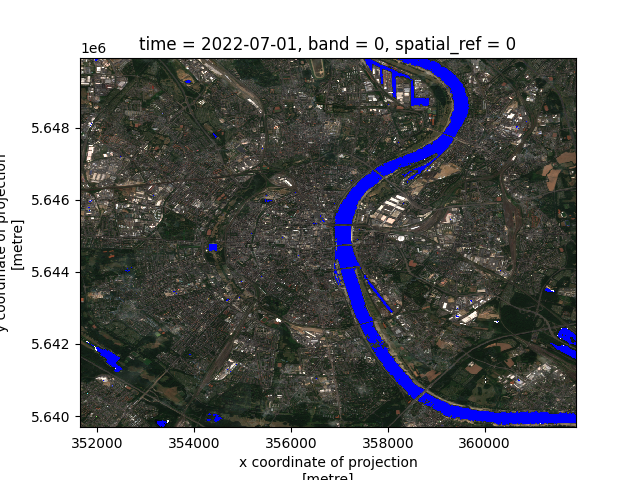

In [13]:
def plot_result():
    with plt.ioff():
        fig, ax = plt.subplots()
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False

    sentinel_data.isel(time=0, band=[0,1,2]).plot.imshow(
        rgb="band",
        vmax=4000,
        ax=ax,
    )

    classified_array.isel(time=0, band=0).plot.imshow(
        ax=ax,
        levels=3,
        colors=["#00000000", "blue"],
        vmax=2,
        add_colorbar=False,
    )

    fig.show()

plot_result()

## Conclusion

In this notebook, we demonstrated a complete workflow for detecting water bodies using Sentinel-2 satellite imagery and a Random Forest classifier. The workflow included data acquisition, preprocessing, model training, and result visualization. By leveraging the Geo Engine platform, we efficiently handled data retrieval, processing, and model deployment.

This example showcased the ease of creating a reusable machine learning pipeline for remote sensing applications. The steps outlined in this notebook can be adapted and extended to other types of classification tasks and datasets, providing a robust framework for developing and deploying machine learning models in geospatial analysis.